Note: Run this notebook on Colab for fastest results

In [1]:
!pip uninstall --yes gdown

!pip install gdown -U --no-cache-dir

Found existing installation: gdown 4.7.3
Uninstalling gdown-4.7.3:
  Successfully uninstalled gdown-4.7.3


In [2]:
from google.colab import drive

In [3]:
# !gdown 1RwhwntZGZ9AX8XtGIDAcQD3ByTcUiOoO #image embeddings
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# !gdown 1b-4hU2Kp93r1nxMUGEgs1UbZov0OqFfW #caption embeddings
# drive.mount('/content/drive/coco_captions.npy')
# drive.mount('/content/drive/MyDrive/coco_captions.npy')
# drive.mount('/content/drive/MyDrive/coco_images.npy')

In [5]:
!wget http://images.cocodataset.org/zips/val2014.zip
!unzip /content/val2014.zip
!wget http://images.cocodataset.org/annotations/annotations_trainval2014.zip
!unzip /content/annotations_trainval2014.zip
!pip install faiss-cpu

Streaming output truncated to the last 5000 lines.
 extracting: val2014/COCO_val2014_000000376046.jpg  
 extracting: val2014/COCO_val2014_000000066394.jpg  
 extracting: val2014/COCO_val2014_000000277584.jpg  
 extracting: val2014/COCO_val2014_000000383518.jpg  
 extracting: val2014/COCO_val2014_000000262466.jpg  
 extracting: val2014/COCO_val2014_000000153055.jpg  
 extracting: val2014/COCO_val2014_000000155312.jpg  
 extracting: val2014/COCO_val2014_000000010440.jpg  
 extracting: val2014/COCO_val2014_000000541108.jpg  
 extracting: val2014/COCO_val2014_000000202503.jpg  
 extracting: val2014/COCO_val2014_000000161308.jpg  
 extracting: val2014/COCO_val2014_000000153013.jpg  
 extracting: val2014/COCO_val2014_000000089924.jpg  
 extracting: val2014/COCO_val2014_000000289842.jpg  
 extracting: val2014/COCO_val2014_000000191226.jpg  
 extracting: val2014/COCO_val2014_000000157465.jpg  
 extracting: val2014/COCO_val2014_000000218224.jpg  
 extracting: val2014/COCO_val2014_000000030548.j

In [6]:
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
from nltk.translate import bleu_score
import faiss
import numpy as np

In [7]:
def get_transform():
    transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),  # convert the PIL Image to a tensor
        transforms.Normalize(
            (0.485, 0.456, 0.406),  # normalize image for pre-trained model
            (0.229, 0.224, 0.225),
        )
    ])
    return transform

coco_dset = dset.CocoCaptions(root = '/content/val2014',
                        annFile = '/content/annotations/captions_val2014.json',
                        transform=get_transform())

print('Number of samples: ', len(coco_dset))
img, target = coco_dset[3] # load 4th sample

print("Image Size: ", img.shape)
print(target)

loading annotations into memory...
Done (t=1.48s)
creating index...
index created!
Number of samples:  40504
Image Size:  torch.Size([3, 224, 224])
['A loft bed with a dresser underneath it.', 'A bed and desk in a small room.', 'Wooden bed on top of a white dresser.', 'A bed sits on top of a dresser and a desk.', 'Bunk bed with a narrow shelf sitting underneath it. ']


In [8]:
ids = list(sorted(coco_dset.coco.imgs.keys()))
captions = []
for i in range(len(ids)):
    captions.append([ele['caption'] for ele in coco_dset.coco.loadAnns(coco_dset.coco.getAnnIds(ids[i]))][:5]) #5 per image
captions_np = np.array(captions)
print('Captions:', captions_np.shape)

Captions: (40504, 5)


In [9]:
captions_flat = captions_np.flatten().tolist()
print('Total captions:', len(captions_flat))

Total captions: 202520


In [10]:
# cap_path = '/content/coco_captions.npy'
cap_path = '/content/drive/MyDrive/coco_captions.npy'
caption_embeddings = np.load(cap_path)
print('Caption embeddings',caption_embeddings.shape)

Caption embeddings (40504, 5, 512)


In [11]:
# img_path = '/content/coco_imgs.npy'
img_path = '/content/drive/MyDrive/coco_imgs.npy'
image_embeddings = np.load(img_path)
print('Image embeddings',image_embeddings.shape)

Image embeddings (40504, 512)


In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import random

warnings.filterwarnings('ignore')

In [13]:
# initialize faiss index for caption and image

image_index = faiss.IndexFlatIP(image_embeddings.shape[1])
image_index.add(image_embeddings)

caption_embedding_sum_per_image = np.sum(caption_embeddings, axis=1)
caption_embeddings_all=np.reshape(caption_embeddings, (caption_embeddings.shape[0]*caption_embeddings.shape[1],caption_embeddings.shape[2]))
caption_index=faiss.IndexFlatIP(caption_embeddings_all.shape[1])
caption_index.add(caption_embeddings_all)


### Task 1

Implemented the algorithm for `k=6` (chosen randomly).

In [23]:
k=6
# finding k nearest images
distances, indices = image_index.search(image_embeddings, k+1)

distances = np.delete(distances, 0, axis=1)
indices = np.delete(indices, 0, axis=1)

queries=[]
for i in range(indices.shape[0]):
  values=caption_embedding_sum_per_image[indices[i]]*distances[i].reshape(1,-1).T
  query=(np.sum(values, axis=0))/(5*k)
  queries.append(query)

dist, indimg=caption_index.search(np.array(queries), 6)

# queries = np.einsum('ijk,ij->ik', caption_embedding_sum_per_image[indices], distances) / (5 * k)

# queries=np.array(queries)
# dist, ind=caption_index.search(queries, 1)
indimg

array([[ 98012,  73601, 152175,  23083,  40164,  40162],
       [ 66978, 112174, 187484,  49486,   5054, 125576],
       [174954, 117551,  26590,  87567,  46290,  24142],
       ...,
       [ 67827, 173356,  94721,  77153,  20888,  87042],
       [  2067,  36122, 131721, 161516,  35559,  49475],
       [ 87411,  87446, 129866,  87445,  87449, 167405]])

In [24]:
final_captions=[]
for i in range(indices.shape[0]):
  for index in indimg[i]:
    if index < i*5 or index >=(i+1)*5:
      final_captions.append(index)
      break


In [25]:
final_captions_fr=[]
for index in final_captions:
  final_captions_fr.append(captions_flat[index])

# ind=np.array(ind.flatten())
# # stst=captions_flat[ind]
# final_captions=[]
# for i in ind:
#   final_captions.append(captions_flat[i])
final_captions_fr

['Two dogs sitting on a bed sleeping on a bed.',
 'A couple of parked motorcycles near a group of people.',
 'A bicycle is parked on a sidewalk as people walk by.',
 'A bedroom with a bed and other furniture in it',
 'The two  giraffes are standing close together.',
 'A living room filled with furniture and a table,',
 'A bird perched on a branch of a tree. ',
 'A living room filled with furniture both in the day and the night.',
 'A baseball player is swinging the bat at a ball.',
 'a table with some dishes with food on it',
 'A bathroom with a sink and other items. ',
 'Two men are playing a video game as another sits watching.',
 'People and cars are passing by this street.',
 'a living room with couches and a table ',
 'A ADULT BROWN BEAR IS IN THE GRASS',
 'A man enjoys cooking food in a pan',
 'A man sitting on the bench talking on his phone.',
 'A kitchen seen is pictured while food is being prepared.',
 'A baseball team plays a game on the field.',
 'A building with a clock on 

In [26]:
def accuracy_v2(predict, real):
    '''
    use bleu score as a measurement of accuracy
    :param predict: a list of predicted captions
    :param real: a list of actual descriptions
    :return: bleu accuracy
    '''
    lower_n_split = lambda x: x.lower().split()

    accuracy = 0
    for i, pre in enumerate(predict):
        refs = real[i]
        score = bleu_score.sentence_bleu(list(map(lambda ref: lower_n_split(ref), refs)), lower_n_split(pre))
        accuracy += score
    return accuracy/len(predict)

accuracy_v2(final_captions_fr,captions_np)

0.07087134353238461

### Task 2

Trying with multiple `k`s

In [27]:
k_values = [2,3,5,7,10,13,16]
k_accuracies=[]

for k in k_values:
  distances, indices = image_index.search(image_embeddings, k+1)

  distances = np.delete(distances, 0, axis=1)
  indices = np.delete(indices, 0, axis=1)

  queries=[]
  for i in range(indices.shape[0]):
    values=caption_embedding_sum_per_image[indices[i]]*distances[i].reshape(1,-1).T
    query=(np.sum(values, axis=0))/(5*k)
    queries.append(query)

  dist, indimg=caption_index.search(np.array(queries), 6)

  final_captions=[]
  for i in range(indices.shape[0]):
    for index in indimg[i]:
      if index < i*5 or index >=(i+1)*5:
        final_captions.append(index)
        break

  final_captions_fr=[]
  for index in final_captions:
    final_captions_fr.append(captions_flat[index])

  k_accuracies.append(accuracy_v2(final_captions_fr,captions_np))
  print("k=",k)
  print(k_accuracies[-1])


k= 2
0.06834846118654395
k= 3
0.07168994171066827
k= 5
0.07134783921801298
k= 7
0.07051834506251713
k= 10
0.06965761263723252
k= 13
0.06687997623957606
k= 16
0.06680329474135745


We see how in this case, accuracy increases till around `k = 3` and then starts decreasing gradually as `k` increases.

### Task 3

Trying different options from FAISS Index Factory for `k=6` (chosen randomly).

In [16]:
k=6

In [17]:
nlist = 100  # Number of clusters
m = 8  # Number of subquantizers
quantizer = faiss.IndexFlatL2(image_embeddings.shape[1])  # Quantizer index
image_index = faiss.IndexIVFPQ(quantizer, image_embeddings.shape[1], nlist, m, 8)
# image_index = faiss.IndexFlatIP(image_embeddings.shape[1])
image_index.train(image_embeddings)
image_index.add(image_embeddings)

caption_embedding_sum_per_image = np.sum(caption_embeddings, axis=1)
caption_embeddings_all=np.reshape(caption_embeddings, (caption_embeddings.shape[0]*caption_embeddings.shape[1],caption_embeddings.shape[2]))

quantizer = faiss.IndexFlatL2(caption_embeddings_all.shape[1])  # Quantizer index
caption_index = faiss.IndexIVFPQ(quantizer, caption_embeddings_all.shape[1], nlist, m, 8)
caption_index.train(caption_embeddings_all)
caption_index.add(caption_embeddings_all)
# caption_index=faiss.IndexFlatIP(caption_embeddings_all.shape[1])

distances, indices = image_index.search(image_embeddings, k+1)

distances = np.delete(distances, 0, axis=1)
indices = np.delete(indices, 0, axis=1)

queries=[]
for i in range(indices.shape[0]):
  values=caption_embedding_sum_per_image[indices[i]]*distances[i].reshape(1,-1).T
  query=(np.sum(values, axis=0))/(5*k)
  queries.append(query)

dist, indimg=caption_index.search(np.array(queries), 6)

final_captions=[]
for i in range(indices.shape[0]):
  for index in indimg[i]:
    if index < i*5 or index >=(i+1)*5:
      final_captions.append(index)
      break

final_captions_fr=[]
for index in final_captions:
  final_captions_fr.append(captions_flat[index])

# final_captions_fr
accuracy_v2(final_captions_fr, captions_np)

0.005848577711727843

In [20]:
nlist = 100  # Number of clusters
quantizer = faiss.IndexFlatL2(image_embeddings.shape[1])  # Quantizer index
image_index = faiss.IndexIVFFlat(quantizer, image_embeddings.shape[1], nlist, faiss.METRIC_L2)
image_index.train(image_embeddings)
image_index.add(image_embeddings)

caption_embedding_sum_per_image = np.sum(caption_embeddings, axis=1)
caption_embeddings_all=np.reshape(caption_embeddings, (caption_embeddings.shape[0]*caption_embeddings.shape[1],caption_embeddings.shape[2]))
# caption_index=faiss.IndexFlatIP(caption_embeddings_all.shape[1])
quantizer = faiss.IndexFlatL2(caption_embeddings_all.shape[1])  # Quantizer index
caption_index = faiss.IndexIVFFlat(quantizer, caption_embeddings_all.shape[1], nlist, faiss.METRIC_L2)
caption_index.train(caption_embeddings_all)
caption_index.add(caption_embeddings_all)

distances, indices = image_index.search(image_embeddings, k+1)

distances = np.delete(distances, 0, axis=1)
indices = np.delete(indices, 0, axis=1)

queries=[]
for i in range(indices.shape[0]):
  values=caption_embedding_sum_per_image[indices[i]]*distances[i].reshape(1,-1).T
  query=(np.sum(values, axis=0))/(5*k)
  queries.append(query)

dist, indimg=caption_index.search(np.array(queries), 6)

final_captions=[]
for i in range(indices.shape[0]):
  for index in indimg[i]:
    if index < i*5 or index >=(i+1)*5:
      final_captions.append(index)
      break

final_captions_fr=[]
for index in final_captions:
  final_captions_fr.append(captions_flat[index])

# final_captions_fr
accuracy_v2(final_captions_fr, captions_np)

0.021471700927422267

In [21]:
caption_index=faiss.IndexFlatIP(caption_embeddings_all.shape[1])
caption_index.add(caption_embeddings_all)

caption_embedding_sum_per_image = np.sum(caption_embeddings, axis=1)
caption_embeddings_all=np.reshape(caption_embeddings, (caption_embeddings.shape[0]*caption_embeddings.shape[1],caption_embeddings.shape[2]))
caption_index=faiss.IndexFlatIP(caption_embeddings_all.shape[1])
caption_index.add(caption_embeddings_all)

distances, indices = image_index.search(image_embeddings, k+1)

distances = np.delete(distances, 0, axis=1)
indices = np.delete(indices, 0, axis=1)

queries=[]
for i in range(indices.shape[0]):
  values=caption_embedding_sum_per_image[indices[i]]*distances[i].reshape(1,-1).T
  query=(np.sum(values, axis=0))/(5*k)
  queries.append(query)

dist, indimg=caption_index.search(np.array(queries), 6)

final_captions=[]
for i in range(indices.shape[0]):
  for index in indimg[i]:
    if index < i*5 or index >=(i+1)*5:
      final_captions.append(index)
      break

final_captions_fr=[]
for index in final_captions:
  final_captions_fr.append(captions_flat[index])

# final_captions_fr
accuracy_v2(final_captions_fr, captions_np)

0.07087134353238461

Here, as it can be seen above, I have tried 3 metrics - IndexFlatIP, IndexIVFFlat, IndexIVFPQ.

| Metrics           |         Accuracy        |     Runtime     |
| :---------------- | :---------------------: | :-------------: |
| IndexFlatIP       |   0.07087134353238461   |  3 min 27 secs  |
| IndexIVFFlat      |   0.021471700927422267  |  48 secs        |
| IndexIVFPQ        |   0.005848577711727843  |  1 min 4 secs   |


Here, we can, to an extent see a tradeoff between speed and accuracy if we compare IndexFlatIP and IndexIVFFFlat. In case of IndexIVFPQ, while it is significantly faster than IndexFlatIP, its accuracy is much lower.

IndexFlatIP having the highest accuracy makes sense as it is based on cosine similarity, which is generally the metric used in case of text embeddings, like the dataset we have worked on in these tasks.


### Task 4

Visualising for a few examples

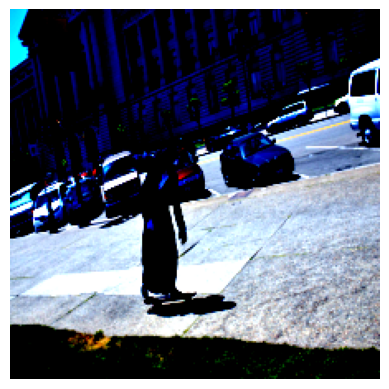

Given captions: ['A person that is riding a skateboard on the street.', 'A nun on a skateboard on the sidewalk.', 'A nun is riding a skateboard on a sidewalk in front of a large concrete building.', 'guy dressed as a nun skateboards down sidewalk', 'A nun riding a skateboard down a sidewalk next to parked cars.']
Predicted caption: A person on the street with a skateboard.
----------------------------------------------------------------- 



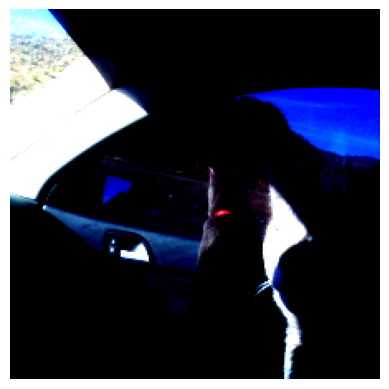

Given captions: ['a couple of cats that are inside of a car', 'Two cats sitting in a car on the passenger seat.', 'A grey cat looks out a car window.', 'Two cats sitting in the front passenger seat of a car', 'a pair of cats riding inside a car']
Predicted caption: A cat sits on the dash of a car.
----------------------------------------------------------------- 



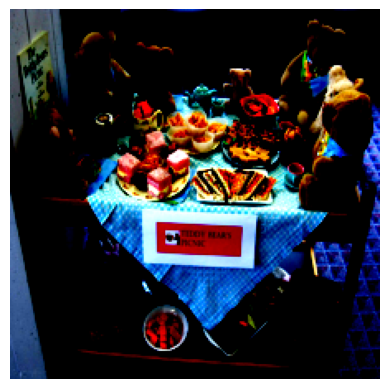

Given captions: ['A cart of finger foods including sandwiches with a group of teddy bears around the plates.', 'a number of stuffed animals near many plates of pastries ', 'A group of teddy bears on a cart loaded with food', 'The teddy bears are posed as if they are eating. ', 'A display of teddy bears and sugary snacks']
Predicted caption: a group of teddy bears in a display 
----------------------------------------------------------------- 



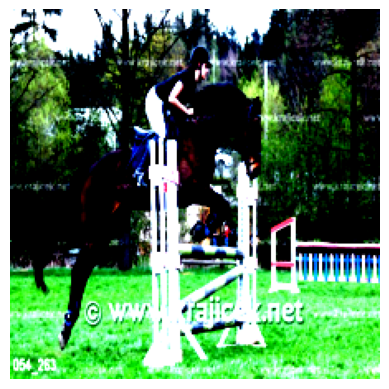

Given captions: ['A young person ridding a horse jumps a gate in a competition.', 'A man riding on a horse as it jumps over a pole. ', 'A woman is riding a horse as it jumps over a bar.', 'there is a woman jockey riding a hose over the hurdle', 'A woman riding a horse jumps over an obstacle.']
Predicted caption: A person riding on a horse while jumping it over an obstacle.
----------------------------------------------------------------- 



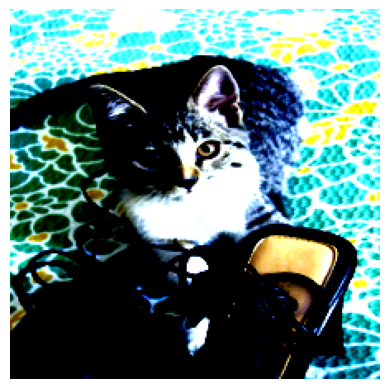

Given captions: ['A cute kitten playing with strings on a shoe.', 'A cat sitting on a floor next to a pair of shoes.', 'a cat sitting with shoes on a bed playing with the strings', 'a small kitten on the floor looking up while standing near some stuff', 'A cat that is looking up while sitting down.']
Predicted caption: A small cat laying its head on a shoe.
----------------------------------------------------------------- 



In [22]:
random_indices = [random.randint(0, len(final_captions_fr)) for _ in range(5)]

for i in random_indices:
  image, caption = coco_dset[i]
  plt.imshow(image.permute(1, 2, 0))  # Permute to (H, W, C) for visualization
  # plt.title(caption[0])  # Display the first caption (there can be multiple captions per image)
  plt.axis('off')
  plt.show()
  print("Given captions:", caption)
  print("Predicted caption:", final_captions_fr[i])
  print("----------------------------------------------------------------- \n")